In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt, random
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn.ensemble
np.random.seed(1)

In [ ]:
#! pip install lime

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import lime.lime_tabular

# Part 1: How do LIME's Parameters Work?

LIME trains local surrogate models to explain individual predictions. That explaination may or may not be helpful.

Local surrogate models with an added interpretability constraint can be expressed as follows:

$explanation(x) = \argmin\limits_{g \in G} L(f,g,π_x) + \Omega(g)$
<br>
\begin{array}{ll}
   g \in G & \text{Choose a model g from all possible models G} \\
   \argmin\limits_{g \in G} \bold{L}( ... ) & \text{that minimizes a loss for} \\
   \argmin\limits_{g \in G} L(\bold{f}, g, \pi_x ) & \text{predictions generated by the black box (f) on perturbed data points} \\
   \argmin\limits_{g \in G} L(f, g, \bold{\pi_x} ) & \text{where a prediction's weight depends on the distance kernel $\pi$ centered at x} \\
   \argmin\limits_{g \in G} L(f, g, \pi_x ) + \bold{\Omega(g)} & \text{and a regularizer penalizes more complex models} \\
\end{array}


In other words, this is how you train a local surrogate model:

1. Select the instance and corresponding black box prediction that you want an explanation of.
2. Perturb your dataset for new points and get the corresponding black box predictions.
3. Weight the new samples by their distance to the instance you chose.
4. Train an interpretable model on the weighted samples.
5. Interpret the local model as a proxy for the black box.

### Parameters in Practice: 2D Case

Visualizing a 2D case, a "black box" function maps x to y. We define it ourselves to see how accurate an explanation a local surrogate model can provide.

An interpretable local surrogate in this case is a line, and we can approximate the relationship between x and y by looking at the line's slope.

In [2]:
# Define our custom black box
def prediction_function(x):
    if (-5 < x) and (x <= 1):
        return (x+2)**2
    elif (x > 1):
        return -(1/10)*(x-1)**2 + 9
    
# Define the slope of the function we want our explanation's slope to match
def prediction_function_gradient(x): 
    # undefined at x=1
    if (-5 < x) and (x < 1):
        return 2*x
    elif (x == 1):
        return None
    elif (x > 1):
        return -(2/10)*x

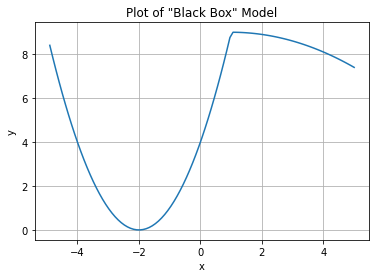

In [3]:
# Plot prediction function
# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate y values using the function
y = np.array([prediction_function(i) for i in x])

# Create the plot
plt.plot(x, y)
plt.title("""Plot of "Black Box" Model""")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

This is the function we'll be working with for this case. We could've chosen any function but this has three roughly linear sections to approximate, so a linear explainer has a chance to capture the black box function's behavior underneath.

Now we'll implement the steps of LIME to choose our explanations. (Let's skip 1 and choose our point of interest later)

#### Step 2: Perturb the dataset for new points

In [4]:
# Note: We don't need to worry about the complexity of this estimator because it is constrained to a single coefficient. So,
complexity = 1 #omega(g)
#[TODO] what would a more complex estimator look like?? quadratic?

# perturb the dataset across the entire space of possible values
# importance of the perturbations to the point of interest will be defined later by the exponential kernel
def generate_perturbed_predictions(num_perturbations, black_box):
    """
    Generates n perturbed data points and their black box predictions.

    Parameters:
        num_perturbations (int): Number of points to generate.
        black_box: model to approximate.

    Returns:
        array: contains the perturbations (x)
        array: contains the predictions (y)
    """
    perturbations = np.random.uniform(-5,5,num_perturbations)
    predictions = np.array([black_box(i) for i in perturbations])
    return perturbations, predictions


In [5]:
# Example Usage - Displaying first 5 values to be concise
num_perturbations = 50
perturbations, predictions = generate_perturbed_predictions(num_perturbations, prediction_function)
perturbations[:5], predictions[:5]

(array([-1.20612181,  1.87766087,  3.67093524, -0.55670653, -3.82413254]),
 array([0.63024258, 8.92297114, 8.28661049, 2.08309604, 3.32745951]))

#### Step 3: Weigh the New Samples
Like most LIME implementations do in practice, we'll use exponential smoothing to make closer samples matter more to the explaination.

Here's a great viz that shows how exponential smoothing works: https://miro.medium.com/v2/resize:fit:1400/1*kgd_wvYc5j80HTDDoafcmQ.gif

In [6]:
# Weigh the new samples according to their proximity - using exponential smoothing as LIME does

def exponential_kernel(x, x0, num_columns, kernel_width):
    """
    Computes the exponential smoothing kernel value for a given x and x0.

    Parameters:
        x (float): Input value.
        x0 (float): Center of the kernel.
        num_columns (int): Number of columns in the training data.

    Returns:
        float: Weight assigned by the exponential kernel.
    """
    # Compute kernel width
    h = kernel_width * np.sqrt(num_columns)
    #can update later to do sqrt(2) based on 2 dimensions for 3d example.
    
    # Compute the kernel value
    weight = np.exp(-np.abs(x - x0) / h)
    return weight


In [7]:
# Example Usage - Displaying first 5 values to be concise
point_of_interest = 2     # Center of the kernel
num_columns = 1  # Since we have 1 x in this example
kernel_width = 0.75

weighed_by_kernel = exponential_kernel(perturbations, point_of_interest, num_columns, kernel_width)
print(f"Kernel Weight: {weighed_by_kernel[:5]}")

Kernel Weight: [1.39144267e-02 8.49490226e-01 1.07753006e-01 3.30761752e-02
 4.24113246e-04]


### Step 4: Train a weighted, interpretable model

Use the weighted, perturbed points to fit the local surrogate.

In [8]:
def use_linear_surrogate(perturbations, predictions):
    """
    Fits a local linear surrogate and returns it and its predictions

    Parameters:
        perturbed_predictions(np.array, np.array): 
            Randomly chosen possible points (perturbations), Outputs of the "black box" for each perturbed point

    Returns:
        function: trained local surrogate model (sklearn linear regressor)
        array: the surrogate's approximations for the perturbed points
    """
    regr = LinearRegression()
    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature
    regr.fit(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), weighed_by_kernel)
    approximation_predictions = regr.predict(perturbations.reshape(-1, 1))
    return regr, approximation_predictions


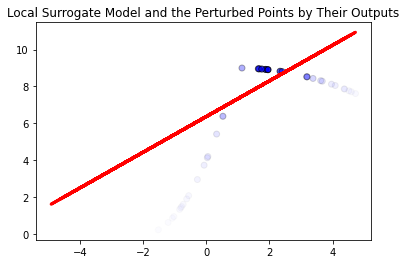

At x = 2
Predicted Slope: 0.967438526216395
Actual Slope:    -0.4


In [9]:
# Example Usage
regr, approximation_predictions = use_linear_surrogate(perturbations, predictions)
# plot the perturbed points
plt.scatter(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), color='blue', alpha=weighed_by_kernel, edgecolors='black', linewidths=1)
# plot the local surrogate
plt.plot(perturbations.reshape(-1, 1), approximation_predictions, color='red', linewidth=3, label='Weighted model')
plt.title("Local Surrogate Model and the Perturbed Points by Their Outputs")
plt.show()
# Print the difference between the estimated relationship and actual relationship x, y
print("At x = "+str(point_of_interest))
print("Predicted Slope: "+str(regr.coef_[0][0]))
print("Actual Slope:    "+str(prediction_function_gradient(point_of_interest)))

#### Step 5: Interpret the local surrogate

Use the following interactive visualization to play around with this example. Notice what happens when the point of interest, kernel width, and number of perturbations changes.

Visualization Key:
- Yellow Star - "Black Box" estimate for point of interest
- Black Line - "Black Box" model being approximated
- Blue Dots - "Black Box" predictions on perturbed points, Size is correlated with weight given by exponential kernel
- Red Line - Local Surrogate Model

In [ ]:
def lime_viz(point_of_interest, num_perturbations, perturbations, predictions, kernel_width=0.75, 
             black_box_function=prediction_function, prediction_function_gradient=prediction_function_gradient, 
             ymin=fixed(-1), ymax=fixed(10)):
    """
    Plots a visual representation of the local surrpogate process.

    Inputs:
        point_of_interest(float): black box point to approximate with the surrogate
        num_perturbations(int): number of perturbations to calculate
        perturbations: Perturbed points in the input space
        predictions: "Black box" outputs for perturbed inputs
        kernel_width: Size of the exponential kernel to use for weighing perturbations

    Returns:
        A visualization of the local surrogate, perturbed and weighted points, and "black box" model.
    """
    plt.clf()
    perturbations = perturbations[:num_perturbations]
    predictions = predictions[:num_perturbations]
    num_columns = 1 #for now working in 1D
    weighed_by_kernel = exponential_kernel(perturbations, point_of_interest, num_columns, kernel_width)

    regr = LinearRegression()
    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature
    regr.fit(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), weighed_by_kernel)
    approximation_predictions = regr.predict(perturbations.reshape(-1, 1))
    
    # Plot prediction function
    x = np.linspace(-5, 5, 100)
    y = np.array([black_box_function(i) for i in x])
    plt.plot(x, y, color='black', zorder=1)

    # Plot perturbed predictions
    plt.scatter(perturbations.reshape(-1, 1), predictions.reshape(-1, 1), color='blue', s=weighed_by_kernel*1000, zorder=2)

    # Plot regression estimate
    plt.plot(perturbations.reshape(-1, 1), approximation_predictions, color='red', linewidth=3, label='Weighted model', zorder=3)

    # Plot point of interest
    plt.scatter(point_of_interest, black_box_function(point_of_interest), color='yellow', s=400, marker='*', edgecolors="black", zorder=4)

    print("Predicted Slope: "+str(regr.coef_[0][0]))
    print("Actual Slope:    "+str(prediction_function_gradient(point_of_interest)))
    #[TODO] Add slope difference

    plt.title("Plot of prediction_function")
    plt.xlim(-5,5)
    plt.ylim(ymin,ymax)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.show()
    

In [ ]:
max_perturbations = 100
perturbations, predictions = generate_perturbed_predictions(max_perturbations, prediction_function)
interact(lime_viz, point_of_interest=(-5,5,.5), 
            num_perturbations=(5,max_perturbations,5), 
            perturbations=fixed(perturbations), 
            predictions=fixed(predictions),
            kernel_width=(0.1,3,0.25),
            black_box_function=fixed(prediction_function),
            prediction_function_gradient=fixed(prediction_function_gradient)
        );


interactive(children=(FloatSlider(value=0.0, description='point_of_interest', max=5.0, min=-5.0, step=0.5), In…

### Can we expect a local surrogate model to be a good estimator?

As we can see above, the parameters have to be chosen appropriately for a surrogate to match the black box well.

At points of interest like $x=-2$ and $x=1$, the model doesn't do a good job at showing what's happening in the function

Beyond this, the local surrogate model has to have a good chance at capturing the model's behavior.

For example, a local surrogate model would have a difficult time explaining points on an oscilating function.

In [12]:
def oscilating_function(x):
    return np.sin(4*x) + 2
def oscilating_gradient(x):
    return 4*np.cos(4*x) 

In [ ]:
perturbations, predictions = generate_perturbed_predictions(max_perturbations, oscilating_function)
interact(lime_viz, point_of_interest=(-5,5,.5), 
            num_perturbations=(5,max_perturbations,5), 
            perturbations=fixed(perturbations), 
            predictions=fixed(predictions),
            kernel_width=(0.1,3,0.25),
            black_box_function=fixed(oscilating_function),
            prediction_function_gradient=fixed(oscilating_gradient),
            ymin=fixed(0),
            ymax=fixed(4)
        );

interactive(children=(FloatSlider(value=0.0, description='point_of_interest', max=5.0, min=-5.0, step=0.5), In…

In this case, unless the number of perturbations is large (100), and kernel width super small (0.1), we don't get a helpful estimate.

We were able to choose such a small kernel size to have an effective approximation only because we knew the underlying distribution. This suggests that in practice, choosing a standard kernel size may not give a good explanation of local behavior. Practitioners should experiment with a range of parameters to determine how stable an explanation is and whether the chosen region of explanation is appropriate.

# Part 2: Sanity Checks 

## Sanity Check 1

## Idea: Local explanations should identify importance locally

**Sanity check: If a feature only gives information for a limited set of points, a local explanation should identify that feature as important only within that set.**

Note: The location of the limited set should not be correlated with the decision boundary of the feature that does not provide additional information. It is likely that a local explanation will learn this relationship.

Example Procedure: 

Test explanations on a two feature model, make the output class depend only on x1 except between x1 values of 1 and 2. Between those values, the output is dependant on x2.

The local explaination should identify x2 as important in that region, but not the other regions.

### Example Where Location of Limited Set is Correlated with x1

#### Create Sample Dataset

In [ ]:
# 2 feature case
# idea: x2 is only informative for 1 < x1 <= 2

# create points that cover the feature region, no info added by x2
feature_names = ["x1", "x2"]
target_names = ["0", "1"]
x1 = np.append(np.arange(0,6,0.1), np.arange(0,6,0.1))
x2 = np.append(np.zeros(len(np.arange(0,6,0.1))), np.ones(len(np.arange(0,6,0.1))))
y = np.zeros(x1.shape)
y[3 < x1] = 1

# switch y label in specific region (1<x1<=2) only where x2=1
y[(x2==1)&(1<x1)&(x1<=2)] = 1

correlation_X = np.append(x1.reshape(len(x1),1),x2.reshape(len(x1),1),axis=1)
correlation_y = y


Text(0, 0.5, 'x2')

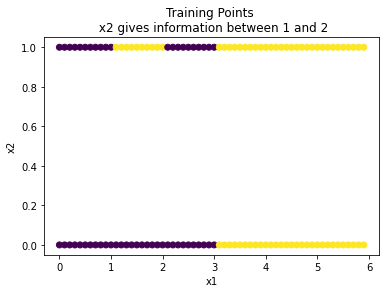

In [ ]:
plt.scatter(
        x=correlation_X[:,0], 
        y=correlation_X[:,1], 
        c=correlation_y
    )
plt.title("Training Points \n x2 gives information between 1 and 2")
plt.xlabel("x1")
plt.ylabel("x2")

#### "Train" a Model on the Dataset

To ensure our model learns the features in the dataset, we can code them into a function directly with decision rules. While this model isn't "trained", its outputs will function the same way a black box model's outputs would.

In [ ]:
def sanity_classifier_correlation(inputs):
    """
    Acts as a decision tree. Is informed by x2 only between 1<x1<=2 
    """
    #custom decisison tree
    results = []
    print(len(inputs), inputs)
    for input in  inputs:
        x1, x2 = input
        if (1 < x1) and (x1 <= 2) and (x2 > 0.5):
            results.append([0.01, 0.99]) #state 1
        elif (1 < x1) and (x1 <= 2) and (x2 <= 0.5):
            results.append([0.99, 0.01]) #state 0
        elif x1 < 3:  
            results.append([0.99, 0.01]) #state 0
        else:
            results.append([0.01, 0.99]) #state 1
    return np.array(results)


#### Create and Examine Local Explainations

In [ ]:
# initialize an instance of LIME
explainer_correlation = lime.lime_tabular.LimeTabularExplainer(
        correlation_X, feature_names=feature_names, 
        class_names=target_names, discretize_continuous=True
    )

In [ ]:
point_of_interest = np.array([1.5,0])
exp = explainer_correlation.explain_instance(
        point_of_interest, sanity_classifier_correlation, num_features=2
    ) #see if i can get back kernel weights

exp.show_in_notebook(show_table=True, show_all=False)

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        0.        ]
 [3.57033408 0.        ]
 [0.64369992 0.        ]
 ...
 [2.40332358 0.        ]
 [2.02464246 0.        ]
 [1.98629048 0.        ]]


LIME Feature Importance:
1.48 < x1 <= 2.95: -0.5406137924756679
x2 <= 0.00: -0.1823397672437765


When examining an instance where we know that x2 decided the label 0, we find that LIME said x2 was less significant than x1.

In [ ]:
point_of_interest = np.array([1.5,1])
exp = explainer_correlation.explain_instance(
        point_of_interest, sanity_classifier_correlation, num_features=2
    ) #see if i can get back kernel weights

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        1.        ]
 [4.3988493  1.        ]
 [0.23480452 1.        ]
 ...
 [3.87830694 0.        ]
 [5.68321502 1.        ]
 [2.55227916 1.        ]]
LIME Feature Importance:
1.48 < x1 <= 2.95: -0.5043345171327028
0.50 < x2 <= 1.00: 0.1545672539927713


For the corresponding instance (x2=1 decided the label 1), we find the same. That LIME said x2 was less significant than x1.

**Important Note:** However, without examining the suggested importance of x2 in other regions, we have no frame of reference to determine if the importance is meaningfully different.

#### Examine Explanations Throughout the Feature Space

Below we plot importance values for all data points in the feature space. The local explainer should identify x2 as more important in the region where it is indeed more important (1<x<=2)

5000 [[0.         0.        ]
 [4.56534819 1.        ]
 [0.13769799 1.        ]
 ...
 [0.97749673 0.        ]
 [5.61261878 0.        ]
 [0.46429184 0.        ]]
5000 [[0.01       0.        ]
 [2.25981738 1.        ]
 [5.60419471 1.        ]
 ...
 [2.58424178 0.        ]
 [4.21493312 1.        ]
 [1.46697765 0.        ]]
5000 [[0.02       0.        ]
 [0.51665857 0.        ]
 [3.81487506 0.        ]
 ...
 [1.95338833 0.        ]
 [3.23715277 1.        ]
 [2.5479523  0.        ]]
5000 [[0.03       0.        ]
 [2.35726376 1.        ]
 [4.82019156 0.        ]
 ...
 [5.43981921 0.        ]
 [4.64026152 1.        ]
 [4.87313886 0.        ]]
5000 [[0.04       0.        ]
 [5.51682884 0.        ]
 [2.17325145 1.        ]
 ...
 [0.37149108 1.        ]
 [1.96567211 0.        ]
 [1.7988496  1.        ]]
5000 [[0.05       0.        ]
 [3.44577309 1.        ]
 [2.72233571 0.        ]
 ...
 [2.05013631 1.        ]
 [2.35565852 0.        ]
 [4.64134586 0.        ]]
5000 [[0.06       0.        ]
 [0.

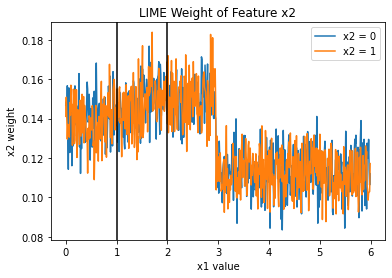

In [ ]:
def plot_importance(chosen_feature, explainer, sanity_classifier):
    global plot_weights
    plot_weights = []
    x1_range = np.arange(0,6,0.01)
    for x2_val in [0,1]:
        xi_weights = []
        for x1_val in x1_range:
            point_of_interest = np.array([x1_val,x2_val])
            exp = explainer.explain_instance(
                    point_of_interest, sanity_classifier, num_features=2
                )
            feature_weights = exp.as_list()
            for feature, weight in feature_weights:
                if chosen_feature in feature:
                    xi_weights.append(weight)
        plot_weights.append(xi_weights)
    
    plt.plot(x1_range, np.abs(plot_weights[0]))
    plt.plot(x1_range, np.abs(plot_weights[1]))
    plt.axvline(x=1, color="black", ymin=0, ymax=1, linestyle="-")
    plt.axvline(x=2, color="black", ymin=0, ymax=1, linestyle="-")
    plt.title(f"LIME Weight of Feature {chosen_feature}")
    plt.xlabel('x1 value')
    plt.ylabel(f'{chosen_feature} weight')
    plt.legend(['x2 = 0', 'x2 = 1'])

plot_importance("x2", explainer_correlation, sanity_classifier_correlation)
plt.show()

It appears that LIME identified that x2 was more important when x1 was less than three, which does accurately capture a pattern we've encoded, but doesn't capture the true region of feature importance.

We add a second region of feature significance to remove the correlation between the x1 value and the relevance of x2. 

### Example Where Location of Limited Set is NOT Correlated with x1

#### Create Sample Dataset

Text(0, 0.5, 'x2')

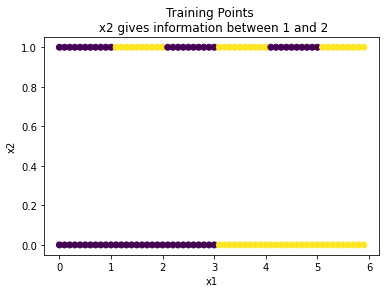

In [ ]:
# 2 feature case
# idea: x2 is informative for 1 < x1 <= 2 and 4 < x1 <= 5

# create points that cover the feature region, no info added by x2
feature_names = ["x1", "x2"]
target_names = ["0", "1"]
x1 = np.append(np.arange(0,6,0.1), np.arange(0,6,0.1))
x2 = np.append(np.zeros(len(np.arange(0,6,0.1))), np.ones(len(np.arange(0,6,0.1))))
y = np.zeros(x1.shape)
y[3 < x1] = 1

# switch y label in specific region (1<x1<=2) only where x2=1
y[(x2==1)&((1<x1)&(x1<=2))] = 1
y[(x2==1)&((4<x1)&(x1<=5))] = 0

no_correlation_X = np.append(x1.reshape(len(x1),1),x2.reshape(len(x1),1),axis=1)
no_correlation_y = y

plt.scatter(
        x=no_correlation_X[:,0], 
        y=no_correlation_X[:,1], 
        c=no_correlation_y
    )
plt.title("Training Points \n x2 gives information between 1 and 2")
plt.xlabel("x1")
plt.ylabel("x2")

#### "Train" a Model on the Dataset

In [ ]:
def sanity_classifier_uncorrelated(inputs):
    """
    Acts as a decision tree. Is informed by x2 only between 1<x1<=2 
    """
    #custom decisison tree
    results = []
    print(len(inputs), inputs)
    for input in  inputs:
        x1, x2 = input
        # x2 significant region 1
        if (1 < x1) and (x1 <= 2) and (x2 > 0.5):
            results.append([0.01, 0.99]) #state 1
        elif (1 < x1) and (x1 <= 2) and (x2 <= 0.5):
            results.append([0.99, 0.01]) #state 0
        # x2 significant region 2
        elif (4 < x1) and (x1 <= 5) and (x2 > 0.5):
            results.append([0.99, 0.01]) #state 0
        elif (4 < x1) and (x1 <= 5) and (x2 <= 0.5):
            results.append([0.01, 0.99]) #state 1
        # everywhere else
        elif x1 < 3:  
            results.append([0.99, 0.01]) #state 0
        else:
            results.append([0.01, 0.99]) #state 1
    return np.array(results)


#### Create and Examine Local Explainations

In [ ]:
# initialize an instance of LIME
explainer_uncorrelated = lime.lime_tabular.LimeTabularExplainer(
        no_correlation_X, feature_names=feature_names, 
        class_names=target_names, discretize_continuous=True
    )

In [ ]:
point_of_interest = np.array([1.5,0])
exp = explainer_uncorrelated.explain_instance(
        point_of_interest, sanity_classifier_uncorrelated, num_features=2
    ) #see if i can get back kernel weights

exp.show_in_notebook(show_table=True, show_all=False)

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        0.        ]
 [0.45813199 1.        ]
 [4.64815763 0.        ]
 ...
 [3.16456616 1.        ]
 [5.1850006  1.        ]
 [2.56797844 0.        ]]


LIME Feature Importance:
1.48 < x1 <= 2.95: -0.47621650302684254
x2 <= 0.00: -0.048566704816082


When examining an instance where we know that x2 decided the label 0, we again find that LIME said x2 was less significant than x1.

In [ ]:
point_of_interest = np.array([1.5,1])
exp = explainer_uncorrelated.explain_instance(
        point_of_interest, sanity_classifier_uncorrelated, num_features=2
    ) #see if i can get back kernel weights

# Extract feature weights from the explanation
feature_weights = exp.as_list()

# Display feature importance
print("LIME Feature Importance:")
for feature, weight in feature_weights:
    print(f"{feature}: {weight}")

5000 [[1.5        1.        ]
 [5.3053674  0.        ]
 [4.10552685 1.        ]
 ...
 [0.63693766 0.        ]
 [5.0870882  1.        ]
 [2.54149799 1.        ]]
LIME Feature Importance:
1.48 < x1 <= 2.95: -0.41880366937914976
0.50 < x2 <= 1.00: 0.026280594631819552


For the corresponding instance of x1 we again find the same.

#### Examine Explanations Throught The Feature Space

5000 [[0.         0.        ]
 [3.90069289 0.        ]
 [3.12996723 0.        ]
 ...
 [4.10380625 0.        ]
 [1.58072267 0.        ]
 [2.0517367  1.        ]]
5000 [[0.01       0.        ]
 [5.37026592 0.        ]
 [3.78746696 1.        ]
 ...
 [0.28114984 0.        ]
 [4.59811994 1.        ]
 [5.20820362 0.        ]]
5000 [[0.02       0.        ]
 [2.58694961 0.        ]
 [1.47661822 1.        ]
 ...
 [5.02087235 1.        ]
 [5.72549686 0.        ]
 [2.4478412  0.        ]]
5000 [[0.03       0.        ]
 [0.59005879 0.        ]
 [3.79840548 0.        ]
 ...
 [1.64698913 1.        ]
 [3.97373778 1.        ]
 [5.60980506 1.        ]]
5000 [[0.04       0.        ]
 [0.505848   1.        ]
 [3.87857238 0.        ]
 ...
 [3.75988148 0.        ]
 [1.2419471  0.        ]
 [5.03987629 1.        ]]
5000 [[0.05       0.        ]
 [1.83691584 1.        ]
 [2.2442329  0.        ]
 ...
 [5.4757407  1.        ]
 [1.66632869 1.        ]
 [2.79199987 0.        ]]
5000 [[0.06       0.        ]
 [0.

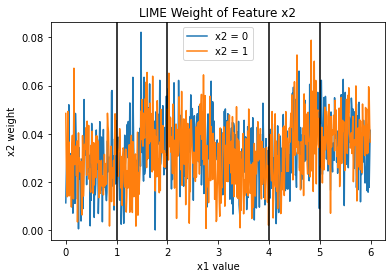

In [ ]:
plot_importance("x2", explainer_uncorrelated, sanity_classifier_uncorrelated)
plt.axvline(x=4, color="black", ymin=0, ymax=1, linestyle="-")
plt.axvline(x=5, color="black", ymin=0, ymax=1, linestyle="-")
plt.show()

When the correlation was removed, LIME found no difference in the local importance of x2. Therefore in this case, LIME was unable to identify the local importance of a causal feature.

### Future Directions for this Sanity Check

- Look at how relative importance changes when varying the size of the density kernel.
- Test on even simpler tabular examples.
- Train a true black box model on a dataset that requires the features be learned and perform the sanity check.

### General Procedure Summary

1. duplicate one column, 
2. add points for specific values of that column where the output is switched (create counterexamples so model has to learn duplicate matters for a region)
3. determine if explainer identifies the duplicate feature as important for the region (it has to be b/c its only way to differentiate in the region)

In our example, LIME uncovered a correlation, that x2 was only important in the region where x1 was 0. However, LIME did not identify the local importance of x2.